# Homework 2

### Due: Wed Nov. 6 @ 11:59pm

In this homework we will be performing model evaluation, model selection and feature selection in both a regression and classification setting.

The data we will be looking at are a small set of home sales data from as we might see on a real-estate website.


## Instructions

Follow the comments below and fill in the blanks (\_\_\_\_) to complete.

Please 'Restart and Run All' prior to submission.

Out of 65 points total.

## Part 0: Environment Setup

In [1]:
# 1. (2pts) Set up our environment with comman libraries and plotting.
#    Note: generally we would do all of our imports here but some imports
#    have been left till later where they are used.

# Import numpy, pandas and matplotlib.pylab
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Execute the matplotlib magic function to display plots inline
%matplotlib inline

# Setting a seed for numpy random
np.random.seed(123)

## Part 1: Regression

In Part 1 we will try to predict a real value home sale price using several models.

In [2]:
# 2. (3pts) Load and prepare our data.

# Read in the csv file house_sales_subset.csv
df = pd.read_csv("../data/house_sales_subset.csv")

# Extract the dataframe X which should contains the first 5 columns:
#    'SqFtTotLiving_x1000', 'SqFtLot_x1000', 'SqFtDriveway_x1000', 'Bathrooms', 'Bedrooms'
X = df.iloc[:,0:5]

# Extract the series y_r which should contain only the last column AdjSalePrice_x100000
#    Note: the '_r' here is denote the different target for regression vs. classification
y_r = df['AdjSalePrice_x100000']

In [3]:
# 3. (4pts) Create a held-aside set.

# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test using train_test_split 
#   Use random_state=42 for grading consistency
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X,y_r,test_size=.2,random_state=42)

# Print out the the length of y_test_r divided by the length y_r to confirm our test set size.
#    Only show 2 significant digits (eg: 0.11).
print('test set size: {:.2f}'.format(y_test_r.shape[0]/y_r.shape[0]))

test set size: 0.20


### Part 1.1 Baseline Regressor

In [4]:
# 4. (4pt) Create a Dummy Regressior for baseline comparison

# Import the DummyRegressor model from sklearn 
from sklearn.dummy import DummyRegressor

# Instantiate a dummy model using strategy="median"
dummy_r = DummyRegressor(strategy='median')

# Train the dummy model on the training set created above
dummy_r.fit(X_train_r,y_train_r)

# Calculate and print the training set R2 score of the trained model.
dummy_r_training_r2 = dummy_r.score(X_test_r,y_test_r)

print('dummy training set R2: {:.2f}'.format(dummy_r_training_r2))

dummy training set R2: -0.06


In [5]:
# 5. (4pts) Use 5-fold Cross Validation to get a set of negative-MSE scores

# Import cross_val_score from sklearn.
from sklearn.model_selection import cross_val_score

# Generate 5-fold cross valication neg_mean_squared_error scores
#    for the Dummy model on the training set.
dummy_r_negmse_cvscores = cross_val_score(dummy_r, X_train_r, y_train_r, cv=5,scoring='neg_mean_squared_error')

In [6]:
# 6. (4pts) Since we'll need to convert from negative-MSE to RMSE several times
#     write a function that takes in a list of negative-MSE scores 
#     and returns positive mean RMSE and 2 times the standard deviation

def negmse_to_rmse(negmse_cvscores):
    
    # Flip the cv scores from negative to positive
    mse_cvscores = -negmse_cvscores

    # Transform the cv scores from MSE to RMSE
    rmse_cvscores = np.sqrt(mse_cvscores)

    # Calculate the mean RMSE over rmse_cvscores
    rmse_mean = np.mean(rmse_cvscores)

    # Calculate 2 standard deviations of rmse_cvscores
    rmse_2std = 2*np.std(rmse_cvscores)
    
    return(rmse_mean,rmse_2std)

In [7]:
# 7. (2pts) Use our negmse_to_rmse function to calculate mean-RMSE 
#     and standard deviations for the dummy model.

# Pass dummy_r_negmse_cvscores to our function and capture the output
dummy_r_rmse,dummy_r_rmse_2std = negmse_to_rmse(dummy_r_negmse_cvscores)

# Print out the mean RMSE and 2 standard variations for the dummy model
print('dummy mean cv RMSE: {:.2f} +- {:.2f}'.format(dummy_r_rmse,dummy_r_rmse_2std))

dummy mean cv RMSE: 2.28 +- 0.35


### Part 1.2 Linear Regression and Residuals

In [8]:
# 8. (4pts) Import the Linear Regression model and calculate mean RMSE using 5-fold Cross Validation

# Import the LinearRegression model from sklearn
from sklearn.linear_model import LinearRegression

# Generate 5-fold cv neg_mean_squared_error scores 
#   for the LinearRegression model with default settings
#   on the training set.
lr_negmse_cvscores = cross_val_score(LinearRegression(), X_train_r, y_train_r, cv=5,scoring='neg_mean_squared_error')

# Use the function we wrote above to get mean RMSE and 2 standard deviations for LinearRegression.
lr_rmse,lr_rmse_2std = negmse_to_rmse(lr_negmse_cvscores)

# Print out the mean RMSE and 2 standard variations for LinearRegression
print('lr mean cv RMSE: {:.2f} +- {:.2f}'.format(lr_rmse,lr_rmse_2std))

lr mean cv RMSE: 1.54 +- 0.20


Text(0, 0.5, 'residuals')

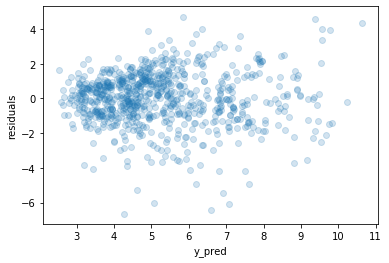

In [9]:
# 9.(6pts) Plot the residuals of a Linear Regression model

# Instantiate and retrain a linear regression model on the entire training set.
lr = LinearRegression().fit(X_train_r,y_train_r)

# Generate predictions y_pred, again using the training set.
y_pred = lr.predict(X_train_r)

# Calculate residuals
#    Recall: residual = y_pred - y
residuals = y_pred - y_train_r

# Plot predictions (x-axis) vs residuals (y-axis) using plt.scatter()
#    In scatter set alpha=0.2 to make the markers somewhat transparent.
#    Set axis/label names appropriately ('y_pred' and 'residuals')
# The residuals should appear fairly normal around 0 across the range of y_pred
plt.scatter(y_pred, residuals, alpha=0.2)
plt.xlabel('y_pred')
plt.ylabel('residuals')

### Part 1.3 ElasticNet HyperParameter Tuning

In [10]:
# 10. (6pts) Use GridSearch to choose an optimal hyperparamter setting for ElasticNet

# Import ElasticNet and GridSearchCV from sklearn
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Perform GridSearch over potential settings of the l1_ratio = [.1,.5,.9,1] 
#     The only parameter in our search is the l1_ratio
#     Use 5-fold cross validation
#     Ust
#     Leave all other arguments as their defaults
#     Fit on the training set
params = {'l1_ratio':[.1,.5,.9,1]}
gscv = GridSearchCV(ElasticNet(),params,cv=5).fit(X_train_r,y_train_r)   

# Print out the best parameter setting found using grid search and the best parameter setting found
print('gscv best params: {}'.format(gscv.best_params_))

gscv best params: {'l1_ratio': 0.1}


In [11]:
# 11. (2pts) Calculate average RMSE for the ElasticNet model using 5-fold Cross Validation

# Instantiate a new ElasticNet model with the optimal l1_ratio found above.
en = ElasticNet(l1_ratio=0.1)

# Generate 5-fold cv neg_mean_squared_error scores 
#   for the instantiated ElasticNet model on the training set.
en_negmse_cvscores = cross_val_score(en, X_train_r, y_train_r, cv=5,scoring='neg_mean_squared_error')

# Use the function we wrote above to get mean RMSE and 
# 2 standard deviations scores.
en_rmse,en_rmse_2std = negmse_to_rmse(en_negmse_cvscores)

# Print out the mean RMSE and 2 standard variations for ElasticNet
print('en mean cv RMSE: {:.2f} +- {:.2f}'.format(en_rmse,en_rmse_2std))

en mean cv RMSE: 1.77 +- 0.26


### Part 1.4 Evaluate on Test

In [12]:
# 12. (3pts) Choose the best model based on mean RMSE, 
#     retrain on the entire training set 
#     and report test set RMSE

# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Retrain the best performaing model on the entire training set
lr = LinearRegression().fit(X_train_r,y_train_r)

# Calculate RMSE on the test set using the trained model
test_rmse = np.sqrt(mean_squared_error(y_test_r,lr.predict(X_test_r)))

print('test RMSE : {:.2f}'.format(test_rmse))

test RMSE : 1.74


---

## Part 2: Classification

Here we build a model to classify low vs. high adjusted sales price.

### Create Classification Target

In [13]:
# We'll create a binary target by thresholding at the median of our AdjSalePrice
#  High = 1, Low = 0
y_c = (df.AdjSalePrice_x100000 > df.AdjSalePrice_x100000.median()).astype(int)

### Part 2.1 Create a Held-Aside Set

In [14]:
# 13. (1pt) Create a training and held aside set

# Split into 80% train and 20% test using train_test_split with random_state=42
#    Use the new y_c target and the same X we used for regression
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X,y_c,test_size=.2,random_state=42)

### Part 2.2 Measure baseline performance

In [15]:
# 14. (1pt) Instead of creating and training a Dummy Classifier, 
#    let's calculate accuracy if we just predict 1 for all training set items.

# Compare all y_train_c to a prediction of 1 and calculate the proportion correct.
baseline_acc = sum(y_train_c == 1) / len(y_train_c)

print('baseline accuracy: {:.2f}'.format(baseline_acc))

baseline accuracy: 0.51


### Part 2.3 Logistic Regression model

In [16]:
# 15. (3pts) Import, train and calculate 5-fold cv accuracy for 
#    a LogisticRegression model on the training set

# Import LogisticRegression model from sklearn
from sklearn.linear_model import LogisticRegression

# Get 5 fold cv accuracy scores for a logistic regression model on the training set
#   Note: in the logistic regression model set solver='lbfgs' to remove warnings
logr_cvscores = cross_val_score(LogisticRegression(solver='lbfgs'),X_train_c,y_train_c,cv=5)

# Calculate mean cv accuracy
logr_acc = np.mean(logr_cvscores)

# Calculate 2 standard deviations for the cv scores
logr_acc_2std = 2*np.std(logr_cvscores)

print('logr mean cv accuracy: {:.2f} +- {:.2f}'.format(logr_acc,logr_acc_2std))

logr mean cv accuracy: 0.75 +- 0.06


In [17]:
# 16. (4pts) Perform 5-fold cross validated grid search over the number of trees and tree depth.

# Import the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Create the grid of parameters to evaluate
#     using the settings n_estimators:[5,100,200], max_depth:[3,5,10].
params = {'n_estimators':[5,100,200],'max_depth': [3,5,10]}

# Instantiate and fit GridSearchCV on the classification training set
#   using 5-folds, the RandomForestClassifier and default scoring.
#   Make sure refit=True (default) so the model is retrained on the entire training set.
gscv = GridSearchCV(RandomForestClassifier(),params,cv=5,refit=True).fit(X_train_c,y_train_c)   

# Print out the best mean accuracy found and the best parameter setting found
print('rf best accuracy: {:.3f}'.format(gscv.best_score_))
print('rf best params  : {}'.format(gscv.best_params_))

rf best accuracy: 0.797
rf best params  : {'max_depth': 10, 'n_estimators': 200}


### Part 2.4 Evaluate on Test

In [18]:
# 17. (3pts) Evaluate the Random Forest Model on the test set

# Get the trained RandomForest model from gscv
# Note: there is no need to retrain here. See the documentation for clarification.
rf = gscv.best_estimator_

# Calculate accuracy on the test set using the trained model
test_acc = rf.score(X_test_c,y_test_c)

print('test acc : {:.2f}'.format(test_acc))

test acc : 0.79


### Part 2.4 Plotting Precision-Recall curve for the Random Forest model

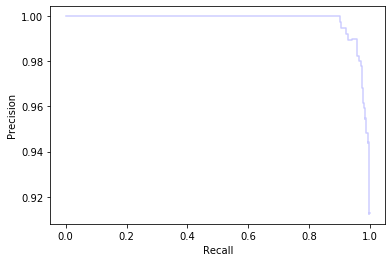

In [19]:
# 18. (5pts) Get the retrained model from gscv and use it to 
#     plot a precision recall curve for the RandomForest model

# import precision_recall_curve from sklearn
from sklearn.metrics import precision_recall_curve

# Calculate P(y=1|x) for the training set using the trained RandomForest model
pypos_rf = rf.predict_proba(X_train_c)[:,1]

# Calculate precision and recall using the y_train_c and pypos_rf
precision, recall, thresholds = precision_recall_curve(y_train_c, pypos_rf)

# Plot the curve using plt.step()
# Recall should be on the x-axis
# Label the x and y axes appropriately
plt.step(recall, precision, color='b', alpha=0.2, where='post');
plt.xlabel('Recall');
plt.ylabel('Precision');

### Part 2.6 Feature selection

In [20]:
# 19. (4pts) Use our trained Random Forest model to determine
#    which features are most important for prediction

# Import SelectFromModel from sklearn
from sklearn.feature_selection import SelectFromModel

# Initialize SelectFromModel using our trained RandomForest model.
#    Use 'mean' as threshold (default).
#    Use prefit=True since the model is already trained/
sfm = SelectFromModel(rf, threshold='mean', prefit=True)

# Get the selected feature names using X.columns and sfm.get_support()
kept_columns =  list(X.columns[sfm.get_support()])

print('kept columns: {}'.format(kept_columns))

kept columns: ['SqFtTotLiving_x1000', 'SqFtLot_x1000']
